# **Diffusion Model（拡散モデル）**

このノートブックでは，拡散モデルの基本的な仕組みから実装，学習，画像生成までの流れを解説します．

拡散モデルは，GAN や VAE に続く画像生成タスクにおいて高い性能を示す生成モデルです．ランダムなノイズから，段階的にノイズを取り除いていくことで画像を生成します．

**※このノートブックの実行には約30分かかります．**

# **ノートブックのアジェンダ**

このノートブックでは，拡散モデルについて以下の流れで学習します．

1. **準備**: 必要なライブラリをインストールします．
2. **拡散モデルの構成**: Forward Process と Reverse Process の概念を理解します．
3. **データセット準備**: MNISTデータセットを読み込み，前処理を行います．
4. **Forward Process（ノイズ付加）の実装**: ノイズスケジュールとノイズ付加関数を実装します．
5. **モデル構築**: ノイズ予測のためのニューラルネットワーク（U-Net）を構築します．
6. **学習**: モデルを学習させ，ノイズ予測の精度を高めます．
7. **サンプリング（生成）**: 学習済みモデルを用いて，ノイズから画像を生成します．
8. **評価**: 生成画像の評価をします．
9. **課題**: さらに深く学習するための課題を提示します．

# **1. 準備**

必要なライブラリをインストールします．

In [ ]:
# 必要なライブラリをインストール
!pip install -q torch torchvision matplotlib tqdm

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from IPython.display import display, Markdown
import math

# **2. 拡散モデルの構成**

拡散モデルは，Forward Process（順方向拡散過程）とReverse Process（逆方向拡散過程）という2つの段階から構成されます．

・**Forward Process（順方向拡散過程）**


画像に徐々にノイズを付与していきます．


・**Reverse Process（逆方向拡散過程）**


順方向拡散過程を逆方向に実施することで完全なノイズから徐々にノイズを取り除き，元の鮮明な画像を生成していきます．
どれぐらいノイズを取り除けばいいかは，事前に学習しているのでそれを使って推定します．


この2つの段階の中で実際に何が行われているかを深堀していきましょう

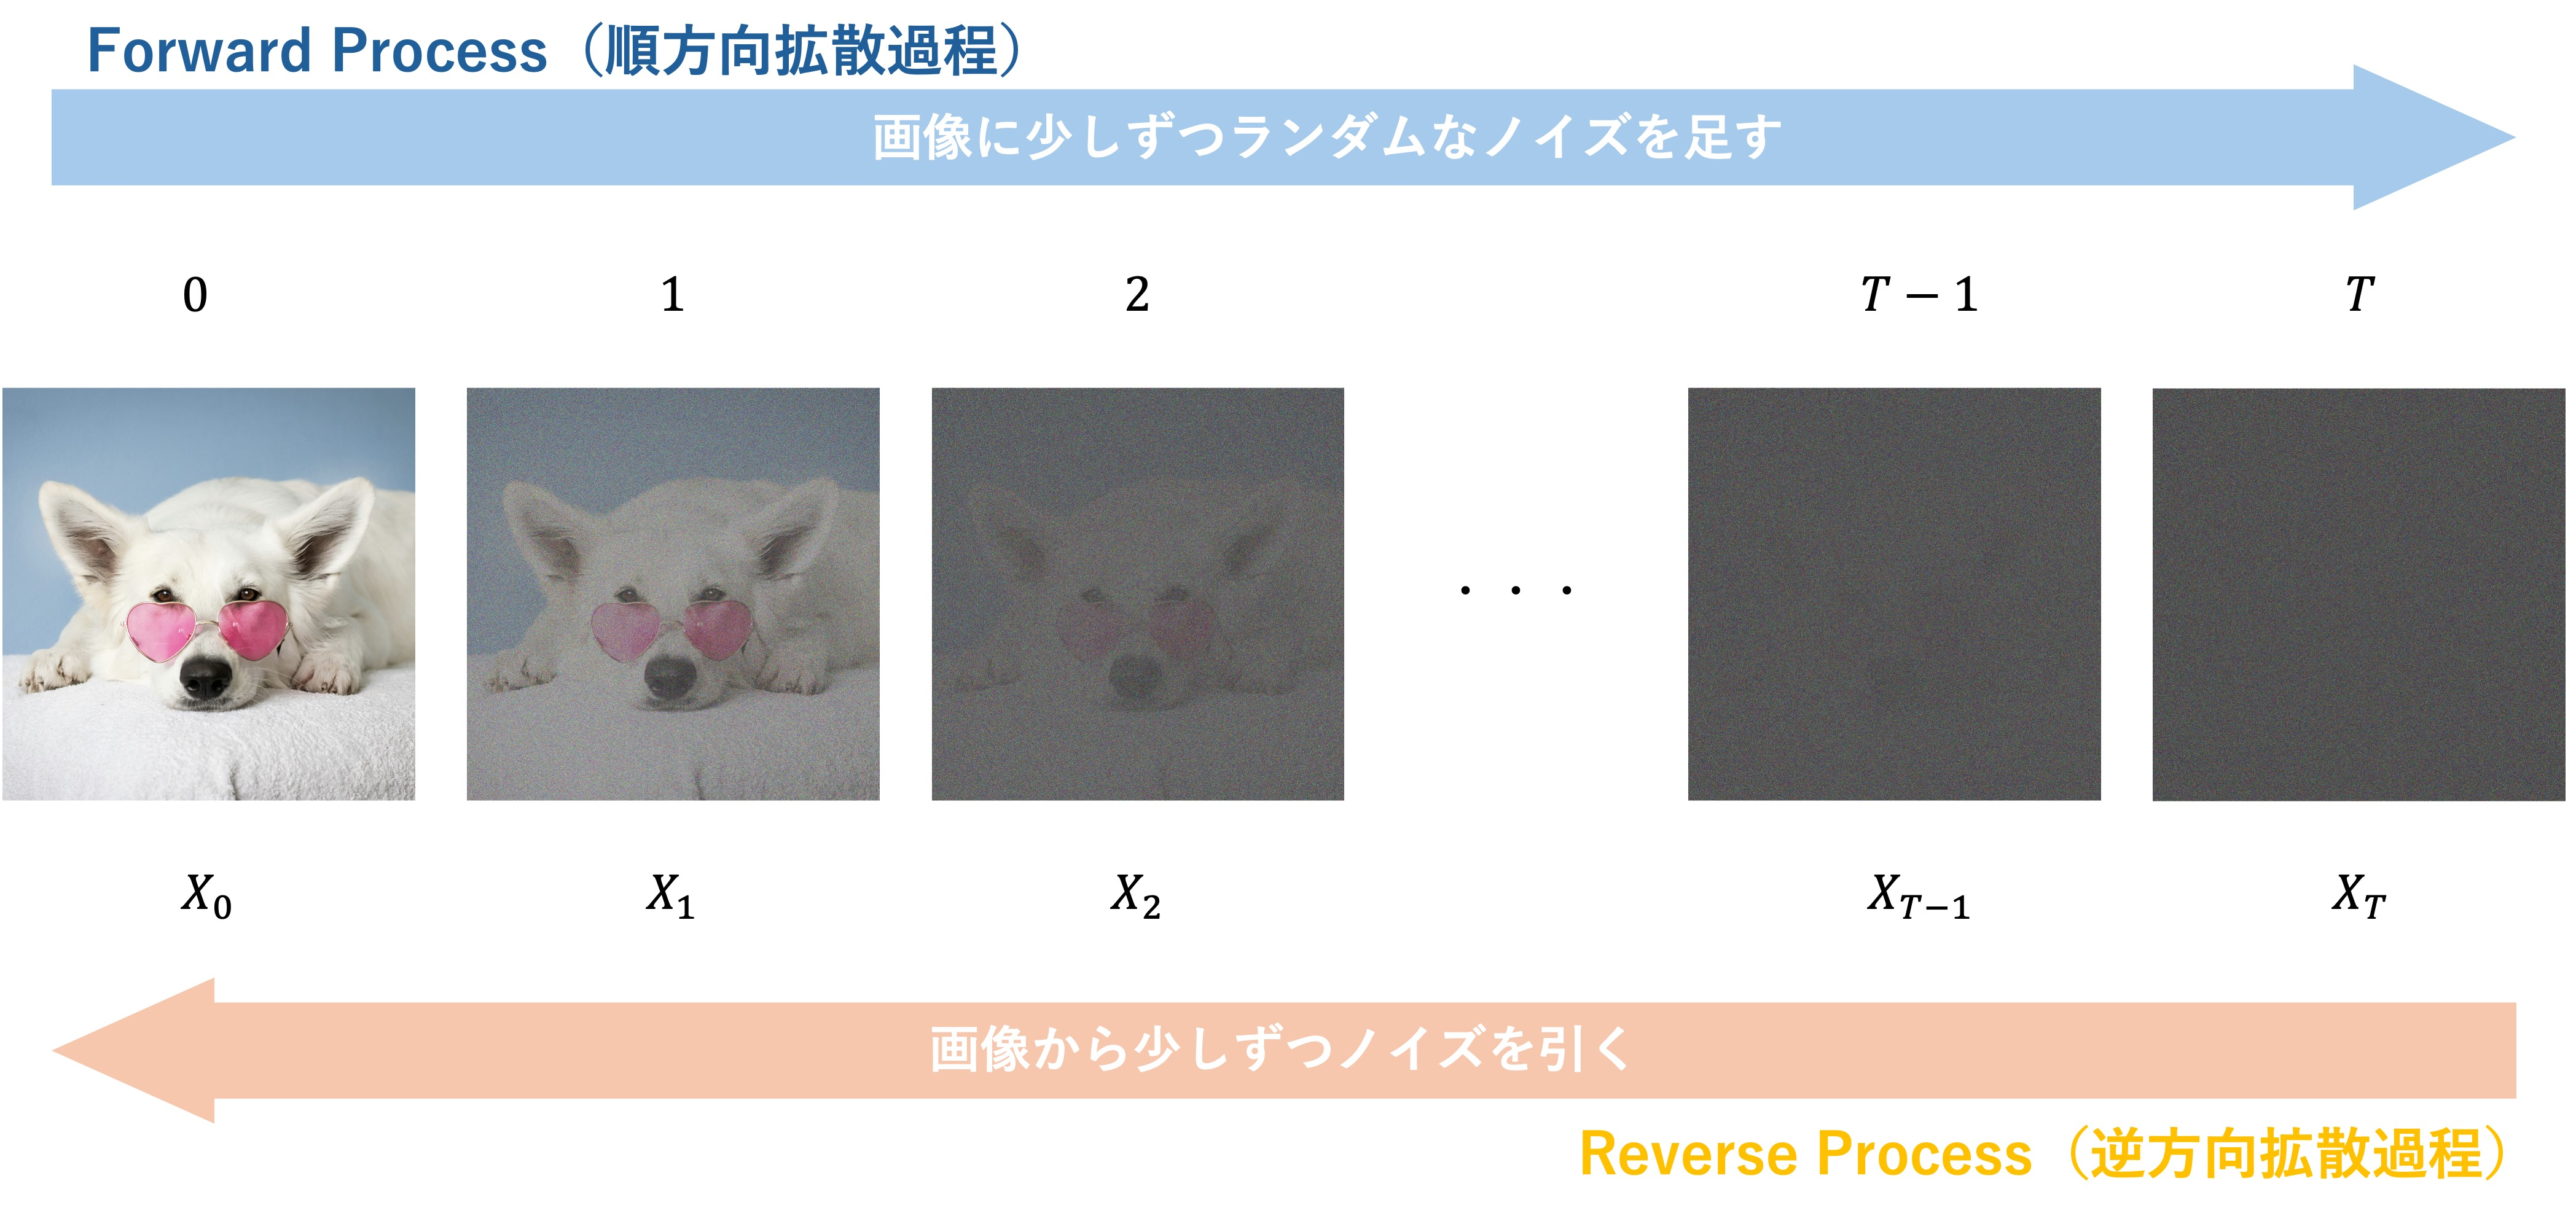

## **Forward Process（順方向拡散過程）**

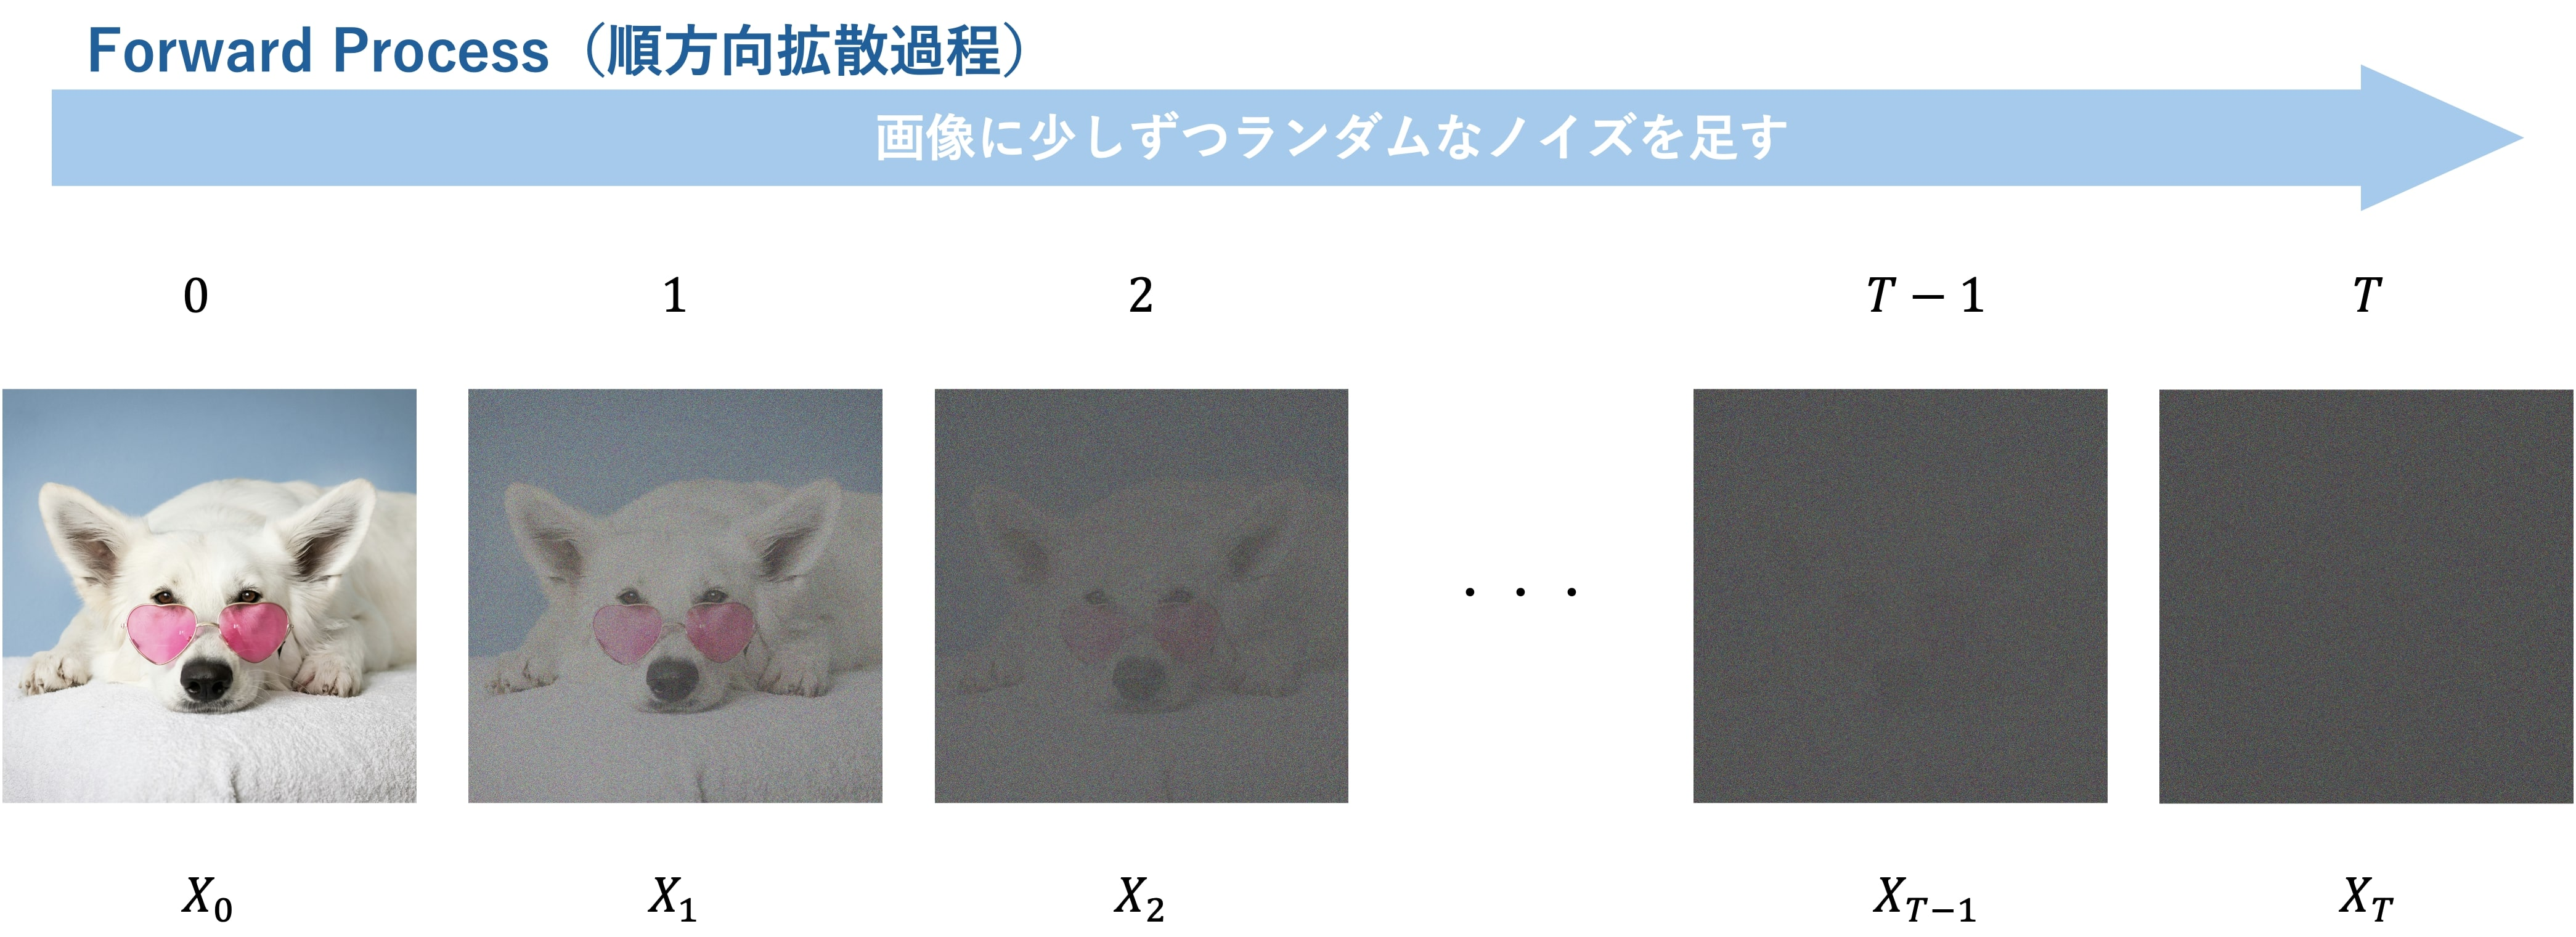

Forward Processでは，データ（この場合は画像 $x_0$）に**段階的に**ノイズを加えていきます．これは，時間ステップ $t=0$ から $T$ にかけて行われ，各ステップで微量のガウスノイズが追加されます．

各タイムステップ $t$ における画像 $x_t$ は，直前のステップの画像 $x_{t-1}$ にノイズを加えることで得られます．このプロセスはマルコフ連鎖として定義され，以下の数式で表されます．

$$q(x_t | x_{t-1}) = \mathscr{N}(x_t; \sqrt{1 - \beta_t} x_{t-1}, \beta_t \mathbf{I})$$

ここで，$\beta_t$ は各タイムステップにおけるノイズの量を制御する**分散スケジュール**です．通常，$\beta_t$ は $t$ の増加とともに単調増加するように設定されます．これにより，時間が進むにつれて画像に加わるノイズの量が増加します．


このマルコフ連鎖の性質により，任意のタイムステップ $t$ における画像 $x_t$ は，初期画像 $x_0$ と分散スケジュール $\beta_1, ..., \beta_t$ を用いて，閉形式で表現することができます．これは，複数のガウス分布の畳み込みが再びガウス分布になるという性質を利用したものです．

$$q(x_t | x_0) = \mathscr{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) \mathbf{I})$$

ここで，$\alpha_t = 1 - \beta_t$ であり，$\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$ です．

この数式は，タイムステップ $t$ における画像 $x_t$ が，初期画像 $x_0$ にノイズを加えたものと等価であることを示しています．時間が十分に進み，$t$ が大きくなる（つまり $\bar{\alpha}_t \to 0$）と，画像 $x_t$ は初期画像 $x_0$ の情報がほとんど失われ，最終的に**完全にノイズ**（標準正規分布に従う）になります．

このForward Processは固定されており，学習は行いません．これは，学習の対象となるReverse Processのための準備段階となります．


## **Reverse Process（逆方向拡散過程）**

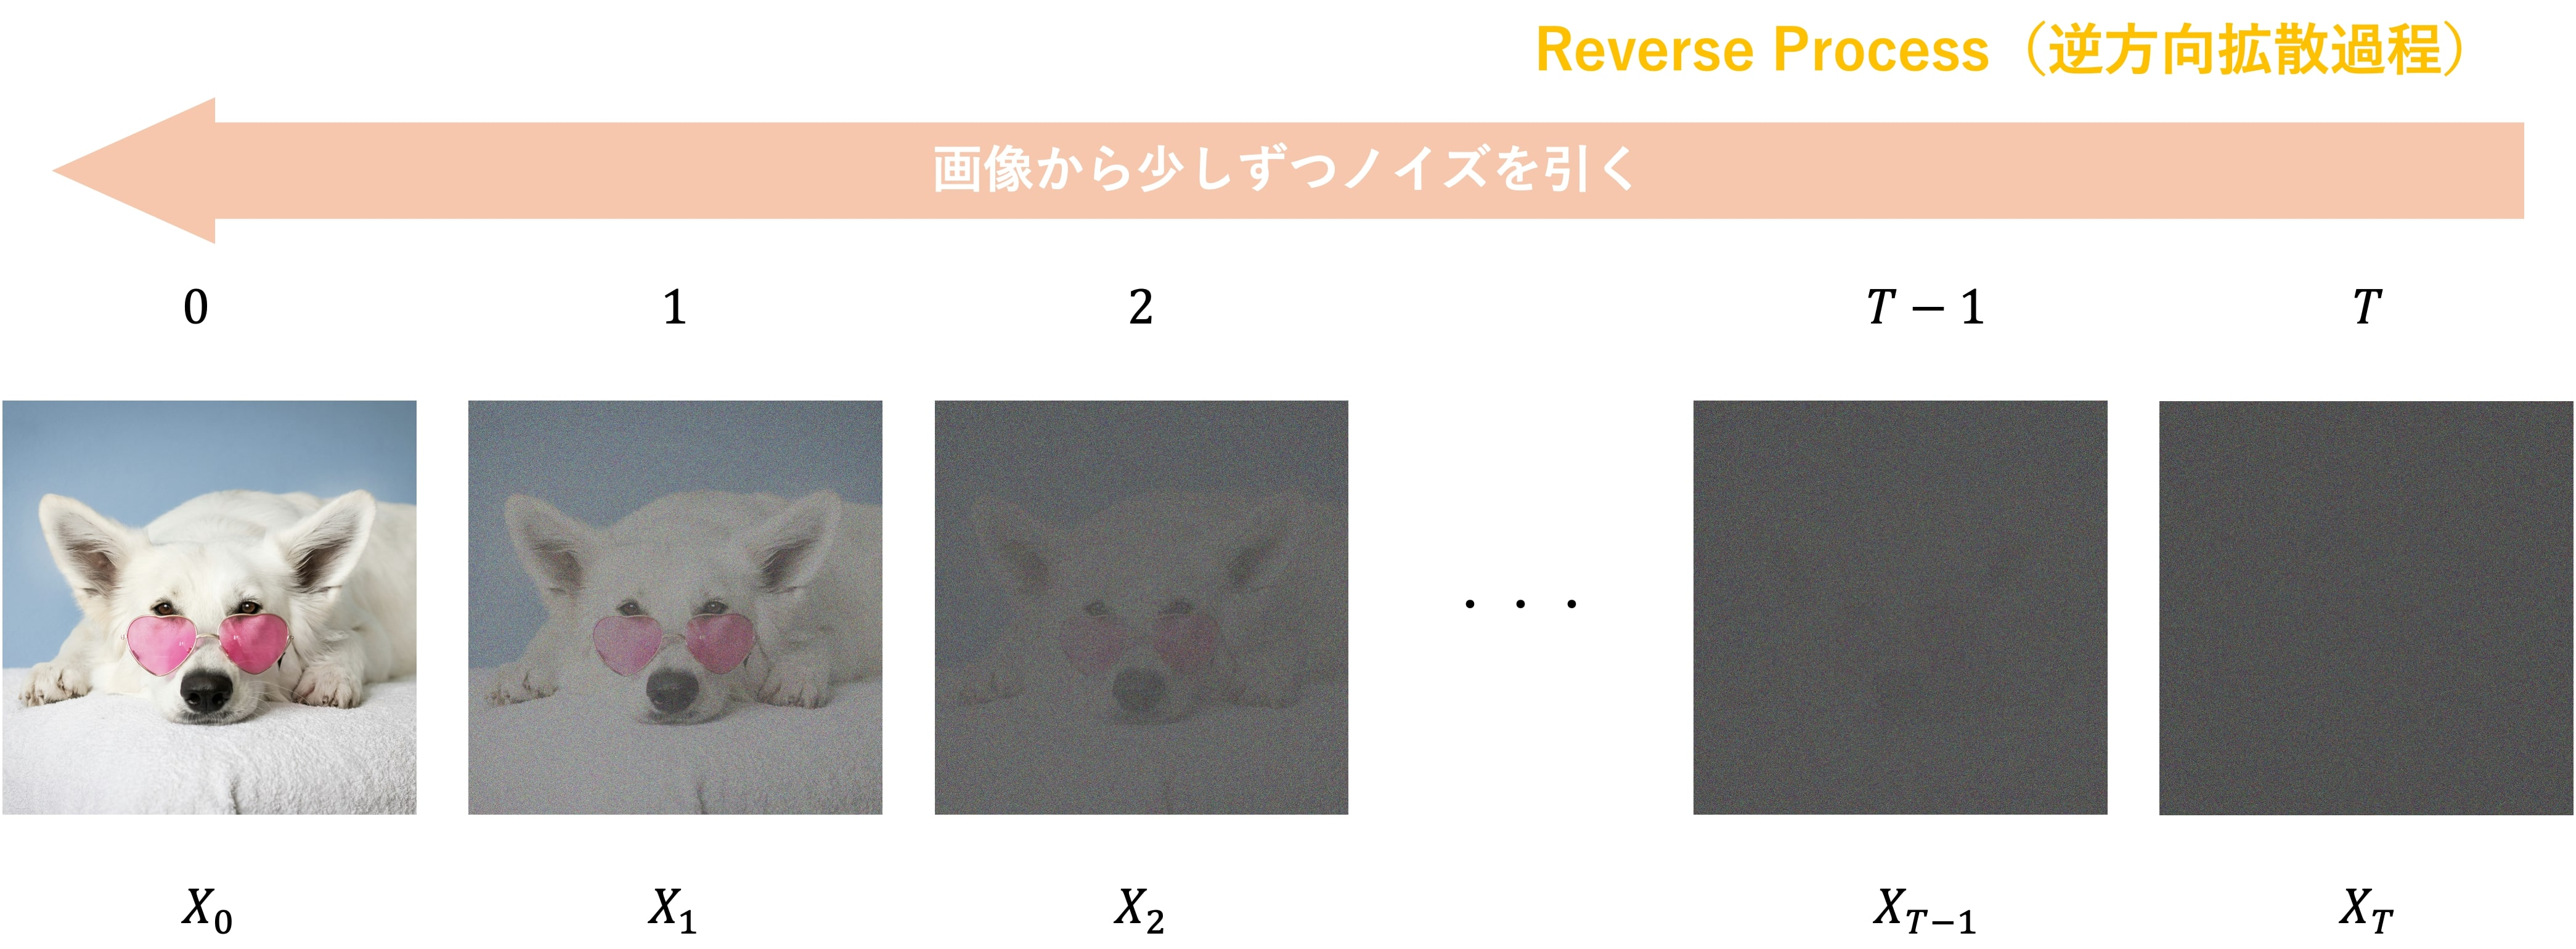

Reverse Process は，Forward Process とは逆方向に，時間ステップ $t=T$ から $0$ にかけてノイズを取り除き，最終的にデータ（画像 $x_0$）を再構築する過程です．これは，純粋なノイズである $x_T$ から開始し，各ステップで少しずつノイズを除去して $x_{T-1}, x_{T-2}, ..., x_0$ を生成していきます．

Reverse Process もマルコフ連鎖として定義されますが，Forward Process とは異なり，この過程の遷移確率 $p(x_{t-1} | x_t)$ は**学習によって求められます**．理論的には，Forward Process の逆方向の遷移 $q(x_{t-1} | x_t)$ は，初期画像 $x_0$ が与えられた場合に計算可能ですが，学習時には $x_0$ が未知であるため，これを直接利用することはできません．

そこで，拡散モデルではニューラルネットワーク（通常は U-Net 構造）を用いて，この逆方向の遷移確率を近似します．具体的には，モデルはタイムステップ $t$ におけるノイズを含む画像 $x_t$ を入力として受け取り，その画像に加えられた**ノイズ $\epsilon$ を予測**するように学習されます．

学習されたモデルを $\epsilon_\theta(x_t, t)$ とすると，Reverse Process の遷移確率 $p_\theta(x_{t-1} | x_t)$ は，予測されたノイズ $\epsilon_\theta(x_t, t)$ を用いて定義されます．シンプルな線形スケジュールの場合，逆拡散ステップは以下のように表されることがあります．

$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right) + \sigma_t z$$

ここで，$z ∼\mathscr{N}(0, \mathbf{I})$ であり，$\sigma_t$ は逆方向の遷移における分散を制御する項です．モデル $\epsilon_\theta(x_t, t)$ は，Forward Process において $x_t$ に加えられた実際のノイズを予測するように学習されます．

つまり，モデルはノイズそのものを予測することで，ノイズが含まれた画像 $x_t$ からノイズを取り除き，$x_{t-1}$ を生成するステップを学習していることになります．Reverse Process を時間ステップ $T$ から $0$ まで繰り返すことで，最終的にノイズが除去されたきれいな画像 $x_0$ が生成されます．

Forward Process が画像にノイズを加えていく過程であるのに対し，Reverse Process は学習されたモデルを使ってそのノイズを取り除き，元の画像を復元する過程です．拡散モデルは，このノイズ除去のプロセスを効果的に学習することで，高品質な画像を生成することを可能にします．

# **3. データセット準備**

ここでは軽量な MNIST データセットを使用します．

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 507kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.3MB/s]


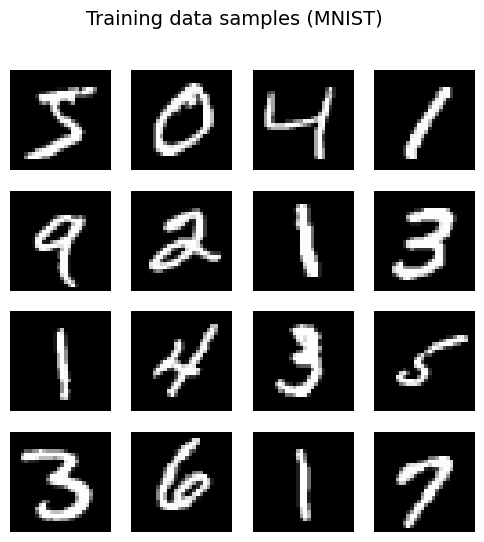

In [ ]:
# MNISTデータセットの読み込み（画像を[-1, 1]に正規化）
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - 0.5) * 2)  # [-1, 1]に正規化
])

# 学習用データセットのダウンロードと作成
dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# データローダー（学習用）
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# データローダー（サンプル可視化用）
sample_dataloader = DataLoader(dataset, batch_size=16, shuffle=False)
sample_batch, _ = next(iter(sample_dataloader))

# サンプル画像の表示（16枚）
plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow((sample_batch[i][0] / 2 + 0.5).cpu(), cmap="gray")  # [0,1]に戻して表示
    plt.axis("off")
plt.suptitle("Training data samples (MNIST)", fontsize=14)
plt.show()


# **4. Forward Process（ノイズ付加）の実装**

Forward Processに必要な β スケジュールと，ノイズを加える関数を実装します．

また，異なるスケジュールに従って画像にノイズがどのように追加されるかを視覚的に確認します．

※各タイムステップtにおけるノイズ強度βtの設計が鍵となっており，β値が小さすぎると学習が遅く ，大きすぎると情報が早期に失われます．

In [ ]:
import torch
import matplotlib.pyplot as plt

class DiffusionScheduler:
    def __init__(self, timesteps, device="cpu"):
        self.timesteps = timesteps
        self.device = device
        self.betas = self.cosine_beta_schedule()
        self.alphas, self.alpha_bars = self.get_alpha_cumulative_products(self.betas)

    def cosine_beta_schedule(self, s=0.008):
        """CosineベースのBetaスケジュール (Improved DDPM)"""
        steps = self.timesteps + 1
        x = torch.linspace(0, self.timesteps, steps, device=self.device)
        alphas_cumprod = torch.cos(((x / self.timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.999)

    def get_alpha_cumulative_products(self, betas):
        alphas = 1. - betas
        alpha_bars = torch.cumprod(alphas, dim=0)
        return alphas, alpha_bars

    def q_sample(self, x_start, t, noise=None):
        """Forward Process: x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * ε"""
        if noise is None:
            noise = torch.randn_like(x_start)
        alpha_bar_t = self.alpha_bars.to(t.device)[t].to(x_start.device)
        alpha_bar_t = alpha_bar_t.view(-1, 1, 1, 1)
        return torch.sqrt(alpha_bar_t) * x_start + torch.sqrt(1. - alpha_bar_t) * noise

    def plot_schedule(self):
        plt.figure(figsize=(10, 4))
        plt.plot(self.betas.cpu().numpy())
        plt.xlabel('Timestep')
        plt.ylabel('Beta Value')
        plt.title('Cosine Beta Schedule')
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.plot(self.alpha_bars.cpu().numpy())
        plt.xlabel('Timestep')
        plt.ylabel('Alpha-bar Value')
        plt.title('Cosine Alpha-bar Schedule')
        plt.grid(True)
        plt.show()


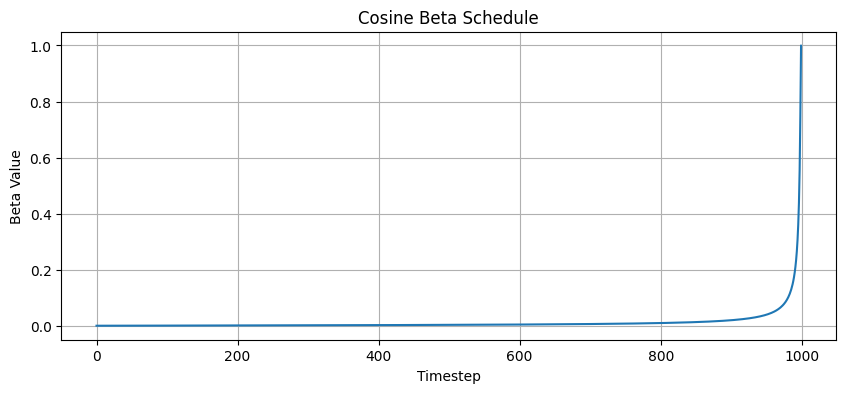

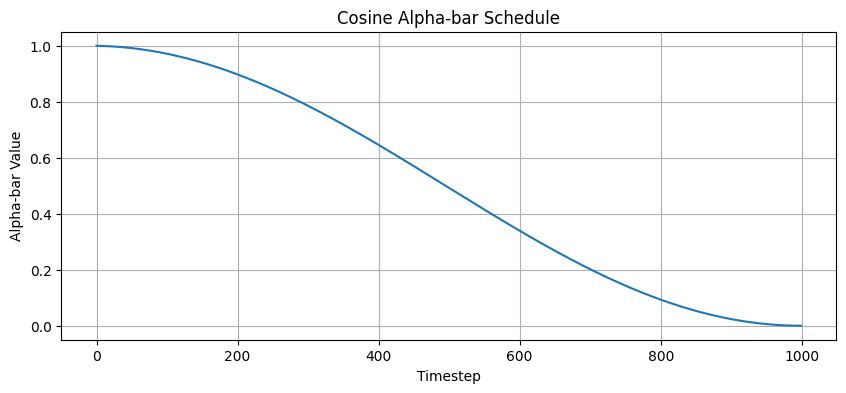

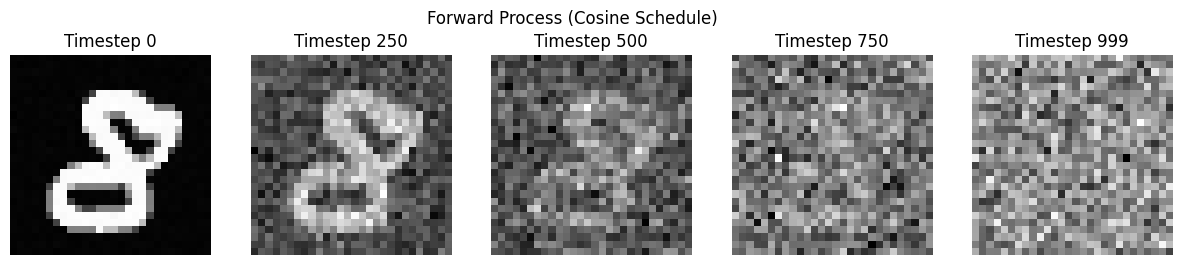

In [ ]:
T = 1000  # タイムステップ数
scheduler = DiffusionScheduler(timesteps=T, device="cuda")

# βとᾱのスケジュール可視化
scheduler.plot_schedule()

# Forward Process 可視化
sample_dataloader_single = DataLoader(dataset, batch_size=1, shuffle=True)
image_tensor, _ = next(iter(sample_dataloader_single))
image_tensor = image_tensor.to("cuda")

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
timesteps_to_show = [0, T//4, T//2, T*3//4, T-1]

for i, t_val in enumerate(timesteps_to_show):
    t = torch.tensor([t_val], device="cuda")
    noisy_image = scheduler.q_sample(image_tensor, t)
    axes[i].imshow((noisy_image[0, 0].cpu() / 2 + 0.5), cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Timestep {t_val}")

plt.suptitle("Forward Process (Cosine Schedule)")
plt.show()


# **5. モデル構築**

ノイズ付き画像からノイズを予測するためのニューラルネットワークを構築します．ここでは，U-NetにResidual Block と Attention 機構を加えたImproved U-Netモデルを使用します．これはより複雑なデータセットにも対応しやすい構造です．

## **Residual Blockの定義**

ディープニューラルネットワークでよく使われる基本的なビルディングブロックです．
2 つの畳み込み層，それに続く Batch Normalization と ReLU 活性化関数から構成されます．
重要な点として，ブロックの入力と出力を足し合わせる**スキップコネクション**を含んでいます．これにより，より深いネットワークの学習において、勾配が流れやすくなることで学習を助けます．

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_embed_dim=None):
        super().__init__()
        # 畳み込み層 + BatchNorm + ReLU
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 時間埋め込みを組み込む層
        self.time_mlp = None
        if time_embed_dim is not None:
            self.time_mlp = nn.Sequential(
                nn.ReLU(),
                nn.Linear(time_embed_dim, out_channels)  # 出力チャンネル数に合わせる
            )

        # 入出力チャンネルが異なる場合のショートカット
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x, t_embed=None):
        out = self.relu(self.bn1(self.conv1(x)))

        # 時間埋め込みを加算
        if self.time_mlp is not None and t_embed is not None:
            time_out = self.time_mlp(t_embed)
            out = out + time_out.view(-1, time_out.shape[-1], 1, 1)  # (B, C, 1, 1)に整形してブロードキャスト

        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # ショートカット接続
        out = self.relu(out)
        return out


## **Attention Block の定義**

Attention は，ネットワークが特徴量を処理する際に，画像内の異なる空間的な位置の重要度を考慮できるようにする仕組みです．これは，画像の長距離依存関係を捉えるのに特に有効です．
学習可能なスケーリングパラメータ gamma を使用して，Attentionの影響度を制御します．

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Query, Key, Value の1x1畳み込み
        self.query = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.key = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.value = nn.Conv2d(channels, channels, kernel_size=1)
        # スケーリングパラメータ（学習可能）
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.size()
        # Query, Key を計算（形状を調整）
        proj_query = self.query(x).view(B, -1, H * W).permute(0, 2, 1)  # (B, HW, C')
        proj_key = self.key(x).view(B, -1, H * W)                       # (B, C', HW)

        # Attention マップを計算
        energy = torch.bmm(proj_query, proj_key)  # (B, HW, HW)
        attention = F.softmax(energy, dim=-1)

        # Value を計算し，Attention を適用
        proj_value = self.value(x).view(B, -1, H * W)                   # (B, C, HW)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))         # (B, C, HW)
        out = out.view(B, C, H, W)                                      # (B, C, H, W)

        # 出力にスケーリングと残差接続を適用
        out = self.gamma * out + x
        return out


## **Improved U-Net モデルの定義**

U-Net は 逆拡散過程（Reverse Process）を近似するニューラルネットです．

エンコーダ（ダウンサンプリング）, ボトルネック, デコーダ（アップサンプリング） から構成されます．

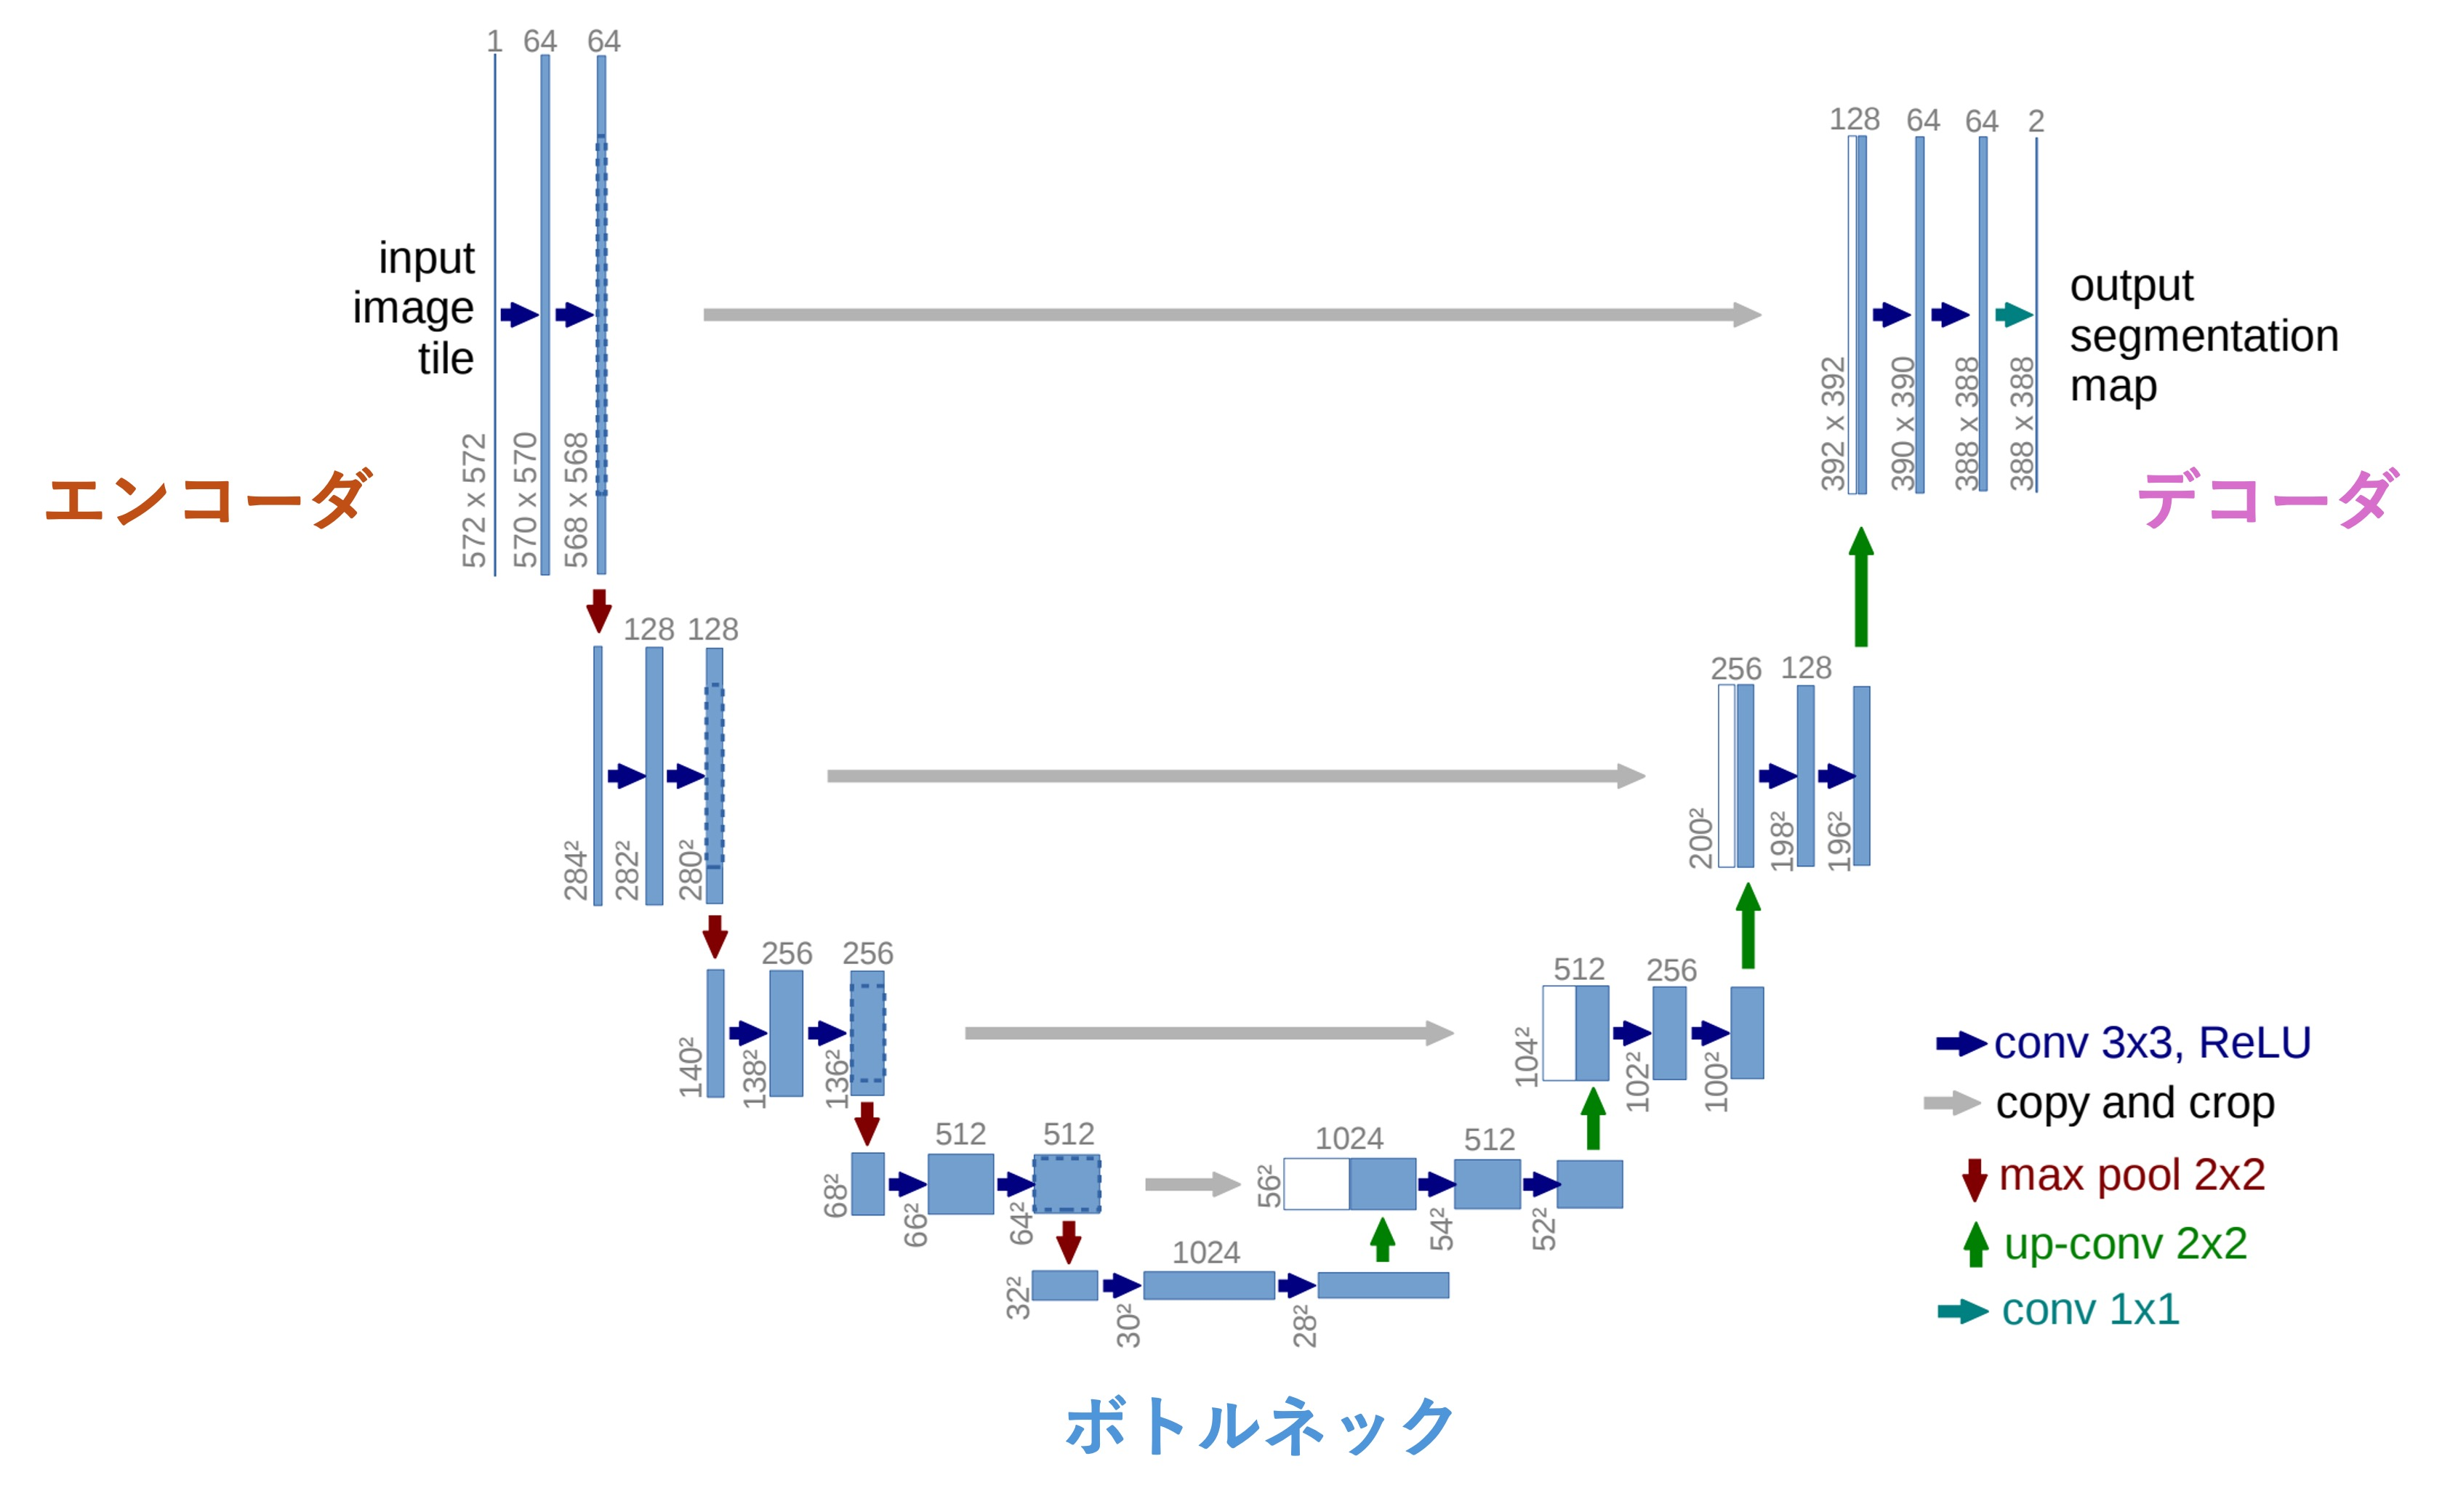

エンコーダ：ResidualBlock + MaxPool2d

- 解像度を下げつつチャネルを増やし，高次特徴を抽出

ボトルネック：ResidualBlock + AttentionBlock

- 抽象度の高い特徴を処理し，大域的関係を捉える

デコーダ：Upsample + ResidualBlock

- 解像度を上げながらチャネルを減らし，画像を復元

- スキップ接続でエンコーダの特徴を利用し，詳細を保持

時間埋め込み：タイムステップ 𝑡を Positional Encoding + MLP で表現

- ResidualBlock に組み込み，出力が 𝑡に依存するようにする

Attention の適用：attention_resolutions で指定した解像度にAttentionBlock を挿入

In [ ]:
class ImprovedUNet(nn.Module):
    def __init__(self, in_channels=1, model_channels=32, out_channels=1, num_residual_blocks=2, attention_resolutions=(8, 16), image_size=28):
        super().__init__()
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_residual_blocks = num_residual_blocks
        self.attention_resolutions = attention_resolutions
        self.image_size = image_size

        # 時間埋め込み（timestep → ベクトル表現）
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.ReLU(),
            nn.Linear(time_embed_dim, time_embed_dim)
        )

        # Positional Encoding (sin, cos)
        half_dim = model_channels // 2
        self.timestep_pe = math.log(10000) / (half_dim - 1)
        self.timestep_pe = torch.exp(torch.arange(half_dim) * -self.timestep_pe)

        # 入力層
        self.input_conv = nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1)

        # Downsampling (エンコーダ)
        self.down_blocks = nn.ModuleList()
        skip_connection_channels = [model_channels]
        curr_channels = model_channels
        num_down_levels = 3
        for i in range(num_down_levels):
            out_channels = curr_channels * 2
            down_block = nn.ModuleList()
            for _ in range(num_residual_blocks):
                down_block.append(ResidualBlock(curr_channels, out_channels, time_embed_dim=time_embed_dim))
                curr_channels = out_channels
            if (image_size // (2**(i+1))) in attention_resolutions:
                down_block.append(AttentionBlock(curr_channels))
            skip_connection_channels.append(curr_channels)
            down_block.append(nn.MaxPool2d(2))
            self.down_blocks.append(down_block)

        # Bottleneck
        bottleneck_in_channels = curr_channels
        self.mid_block1 = ResidualBlock(bottleneck_in_channels, bottleneck_in_channels, time_embed_dim=time_embed_dim)
        self.mid_attention = AttentionBlock(bottleneck_in_channels)
        self.mid_block2 = ResidualBlock(bottleneck_in_channels, bottleneck_in_channels, time_embed_dim=time_embed_dim)

        # Upsampling (デコーダ)
        self.up_blocks = nn.ModuleList()
        up_in_channels = bottleneck_in_channels
        skip_channels_list = skip_connection_channels[:-1][::-1]
        for i in range(num_down_levels):
            skip_channels = skip_channels_list[i]
            out_channels = skip_channels
            up_block = nn.ModuleList()
            up_block.append(nn.Upsample(scale_factor=2, mode='nearest'))
            up_block.append(ResidualBlock(up_in_channels + skip_channels, out_channels, time_embed_dim=time_embed_dim))
            for _ in range(num_residual_blocks - 1):
                up_block.append(ResidualBlock(out_channels, out_channels, time_embed_dim=time_embed_dim))
            if (image_size // (2**(num_down_levels - 1 - i))) in attention_resolutions:
                up_block.append(AttentionBlock(out_channels))
            self.up_blocks.append(up_block)
            up_in_channels = out_channels

        # 出力層
        self.final_upsample = nn.Upsample(size=(image_size, image_size), mode='nearest')
        self.final_output_conv = nn.Conv2d(model_channels, self.out_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        # 時間埋め込み (Positional Encoding → MLP)
        t = t.squeeze().float()
        t_pe = t.unsqueeze(-1) * self.timestep_pe.to(x.device)
        t_pe = torch.cat((torch.sin(t_pe), torch.cos(t_pe)), dim=-1)
        t_embed = self.time_embed(t_pe)

        # 入力層
        h = self.input_conv(x)
        skip_connections = [h]

        # Downsampling path
        for down_block in self.down_blocks:
            for layer in down_block:
                if isinstance(layer, ResidualBlock):
                    h = layer(h, t_embed)
                else:
                    h = layer(h)
            skip_connections.append(h)

        # Bottleneck
        h = self.mid_block1(h, t_embed)
        h = self.mid_attention(h)
        h = self.mid_block2(h, t_embed)

        # Upsampling path
        skip_connections = skip_connections[::-1]
        for i, up_block in enumerate(self.up_blocks):
            h = up_block[0](h)  # Upsample
            skip_conn = skip_connections[i + 1]
            min_h, min_w = h.shape[-2], h.shape[-1]
            skip_conn_cropped = skip_conn[..., :min_h, :min_w]
            h = torch.cat([h, skip_conn_cropped], dim=1)
            for layer in up_block[1:]:
                if isinstance(layer, ResidualBlock):
                    h = layer(h, t_embed)
                else:
                    h = layer(h)

        # 出力
        h = self.final_output_conv(h)
        h = self.final_upsample(h)
        return h


ImprovedUNetのインスタンス化

In [ ]:
# ImprovedUNet インスタンス化（MNIST用）
# 入力1ch → 出力1ch，画像サイズ28x28
improved_model_mnist = ImprovedUNet(in_channels=1, out_channels=1, image_size=28).to("cuda")
print("ImprovedUNet (MNIST) initialized.")

# ImprovedUNet インスタンス化（CIFAR-10用）
# 入力3ch → 出力3ch，画像サイズ32x32
# モデル規模を大きめに設定（channels=64, residual=3）
improved_model_cifar10 = ImprovedUNet(in_channels=3, out_channels=3, image_size=32,
                                      model_channels=64, num_residual_blocks=3).to("cuda")
print("ImprovedUNet (CIFAR-10) initialized.")

ImprovedUNet (MNIST) initialized.
ImprovedUNet (CIFAR-10) initialized.


# **6. 学習**

モデルを学習させ，Forward Processでノイズを加えた画像からそのノイズを予測できるようにします．損失関数にはMSE（平均二乗誤差）を使用します．また，学習曲線の可視化も行います．

Training starts...
Epoch [1/1], Step [100/469], Loss: 0.9053
Epoch [1/1], Step [200/469], Loss: 0.7489
Epoch [1/1], Step [300/469], Loss: 0.6627
Epoch [1/1], Step [400/469], Loss: 0.6027
Epoch [1/1] Average Loss: 0.7612
Training finished.


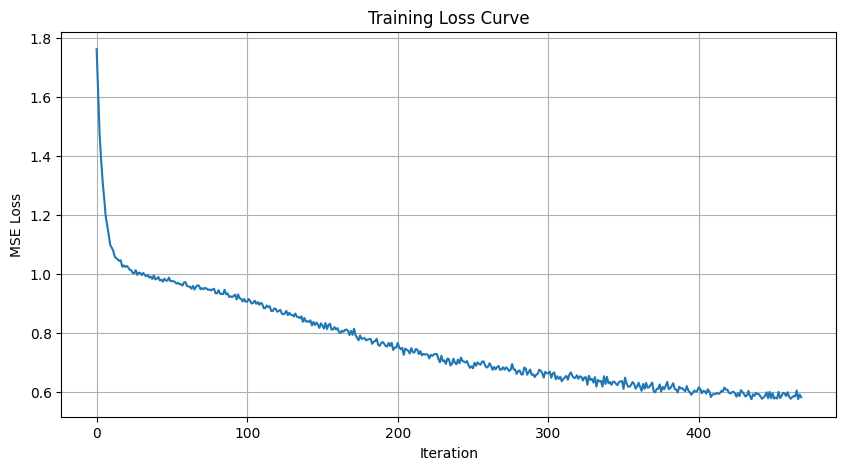

In [ ]:
n_epochs = 1
optimizer = torch.optim.Adam(improved_model_mnist.parameters(), lr=1e-4)
loss_history = []

# モデルをGPUに
improved_model_mnist = improved_model_mnist.to("cuda")
improved_model_mnist.train()

print("Training starts...")
for epoch in range(n_epochs):
    total_loss = 0
    for step, (x, _) in enumerate(dataloader):
        x = x.to("cuda")
        batch_size = x.size(0)

        # ランダムなタイムステップ t
        t = torch.randint(0, T, (batch_size,), device="cuda").long()

        # ノイズ生成
        noise = torch.randn_like(x)

        # Forward Process（q_sample内でα-bar参照）
        x_noisy = scheduler.q_sample(x_start=x, t=t, noise=noise)

        # モデルがノイズを予測
        pred_noise = improved_model_mnist(x_noisy, t)

        # MSE損失
        loss = F.mse_loss(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loss_history.append(loss.item())

        if (step + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Step [{step+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{n_epochs}] Average Loss: {avg_loss:.4f}")

print("Training finished.")

# 学習曲線
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()


# **7. サンプリング（生成）**

学習済みモデルを使って，ノイズから画像を生成します．**Reverse Process（逆方向拡散過程）**のアルゴリズムを実行します．

In [ ]:
class DiffusionSampler:
    """
    Diffusion Model の Reverse Process を実行するサンプラクラス．
    モデル（通常はU-Net）とスケジュールパラメータを受け取り，
    ノイズから画像を段階的に生成する．
    """

    def __init__(self, model, alphas, alpha_bars, betas, device="cuda"):
        self.model = model.to(device).eval()
        self.alphas = alphas.to(device)
        self.alpha_bars = alpha_bars.to(device)
        self.betas = betas.to(device)
        self.device = device

    # --------------------------------------------------------
    # 1ステップの逆拡散: x_t → x_{t-1}
    # --------------------------------------------------------
    @torch.no_grad()
    def p_sample(self, x_t, t):
        """
        Reverse Process の1ステップ (x_t → x_{t-1}) を実行．
        """
        # スケジュールパラメータの取得
        t = t.long().squeeze()
        beta_t = self.betas[t].view(-1, 1, 1, 1)
        alpha_t = self.alphas[t].view(-1, 1, 1, 1)
        alpha_bar_t = self.alpha_bars[t].view(-1, 1, 1, 1)

        # モデルがノイズを予測
        pred_noise = self.model(x_t, t)

        # ノイズ除去により x_0 を推定
        x0_pred = (x_t - torch.sqrt(1 - alpha_bar_t) * pred_noise) / torch.sqrt(alpha_bar_t)
        x0_pred = torch.clamp(x0_pred, -1., 1.)

        # 平均 μ_t と分散 σ_t
        mu_t = (x_t - (beta_t / torch.sqrt(1 - alpha_bar_t)) * pred_noise) / torch.sqrt(alpha_t)
        sigma_t = torch.sqrt(beta_t)

        # サンプリング: t > 0 ならノイズを加える
        if t[0] > 0:
            noise = torch.randn_like(x_t)
            x_t_minus_1 = mu_t + sigma_t * noise
        else:
            x_t_minus_1 = mu_t

        return torch.clamp(x_t_minus_1, -1., 1.)

    # --------------------------------------------------------
    # 全ステップの逆拡散: x_T → x_0
    # --------------------------------------------------------
    @torch.no_grad()
    def sample(self, img_size, num_steps, num_samples=1, save_interval=0.1):
        """
        Reverse Process を num_steps ステップ繰り返し，
        ノイズから画像を生成する．
        """
        print(f"Starting sampling ({num_steps} steps)...")
        x = torch.randn(num_samples, self.model.in_channels, img_size, img_size, device=self.device)
        history = [x.cpu()]  # 生成過程を保存

        step_interval = max(1, int(num_steps * save_interval))

        for step in reversed(range(num_steps)):
            t = torch.full((num_samples,), step, device=self.device, dtype=torch.long)
            x = self.p_sample(x, t)

            if step % step_interval == 0 or step == 0:
                print(f"  ↳ Step {step:>4d} | Progress: {(1 - step / num_steps):.0%}")
                history.append(x.cpu())

        print("Sampling complete.")
        return x.cpu(), history


In [ ]:
# サンプラを初期化
sampler = DiffusionSampler(
    model=improved_model_mnist,
    alphas=scheduler.alphas,
    alpha_bars=scheduler.alpha_bars,
    betas=scheduler.betas,
    device="cuda"
)

# 画像生成
num_generated_samples = 16
img_size = 28
generated_images, generation_process_imgs = sampler.sample(
    img_size=28,
    num_steps=T,
    num_samples=num_generated_samples,
    save_interval=0.1  # 10%刻みで途中経過を記録
)


Starting sampling (1000 steps)...
  ↳ Step  900 | Progress: 10%
  ↳ Step  800 | Progress: 20%
  ↳ Step  700 | Progress: 30%
  ↳ Step  600 | Progress: 40%
  ↳ Step  500 | Progress: 50%
  ↳ Step  400 | Progress: 60%
  ↳ Step  300 | Progress: 70%
  ↳ Step  200 | Progress: 80%
  ↳ Step  100 | Progress: 90%
  ↳ Step    0 | Progress: 100%
Sampling complete.


# **8. 評価**

拡散モデルの評価は主に 定性的評価（目視での画像品質確認）と 定量的評価（数値指標による評価）に分かれます．

**8.1 定性的評価**

実際に生成された画像を観察し，評価します．

MNISTのような単純なデータセットでは，数字の形状が明瞭に判別できるか，ノイズが残っていないかを確認します．

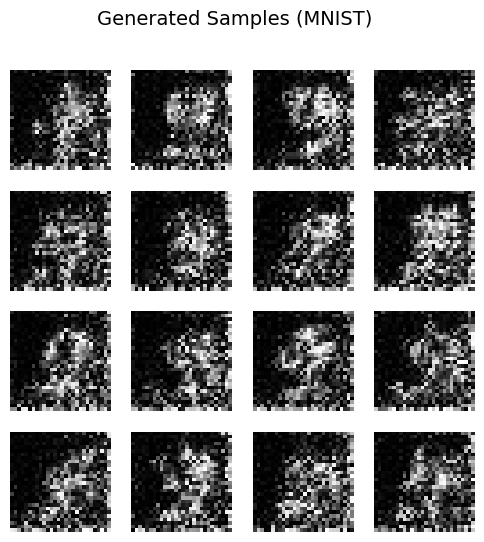

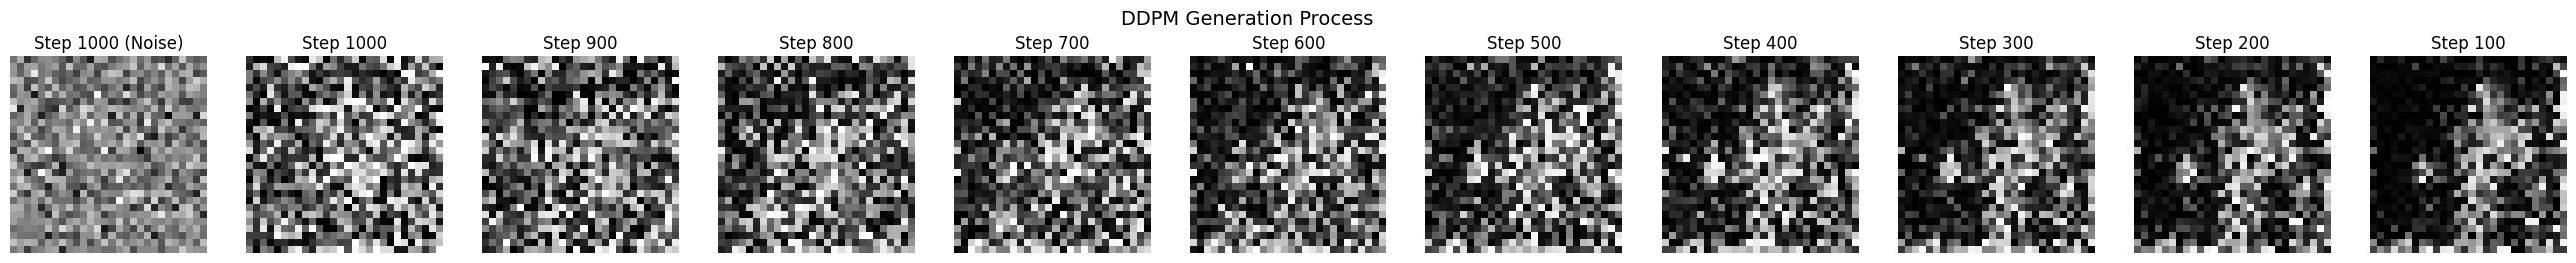

In [ ]:
# 最終生成画像を可視化
plt.figure(figsize=(6,6))
for i in range(num_generated_samples):
    plt.subplot(4, 4, i+1)
    # [-1,1] → [0,1] に変換して表示
    plt.imshow((generated_images[i][0] / 2 + 0.5), cmap="gray")
    plt.axis("off")
plt.suptitle("Generated Samples (MNIST)", fontsize=14)
plt.show()

# 生成過程を可視化
fig, axes = plt.subplots(1, len(generation_process_imgs), figsize=(3 * len(generation_process_imgs), 3))
for i, img_tensor in enumerate(generation_process_imgs):
    ax = axes[i]
    # バッチ先頭の画像のみ表示
    ax.imshow((img_tensor[0, 0].cpu() / 2 + 0.5), cmap="gray")
    ax.axis("off")
    if i == 0:
        ax.set_title(f"Step {T} (Noise)")
    else:
        # 対応するタイムステップを表示
        step_val = T - (i-1)*(T // 10) if i > 0 else T
        ax.set_title(f"Step {step_val}")
plt.suptitle("DDPM Generation Process", fontsize=14)
plt.show()


**8.2 定量的評価**

生成画像の質を客観的に測るために，FID（Fréchet Inception Distance）がよく用いられます．

```
FIDとは?

* Inception V3 で抽出した特徴量（2048次元）を使い，実画像と生成画像の分布をガウス分布で近似します．

* その平均と分散を比較して，分布の近さを評価します．

* 値が小さいほど「実データに近い生成」ができていることを示します．

FIDは以下の式で表されます：

$$
FID = \lVert \mu_r - \mu_g \rVert^2
    + \mathrm{Tr}\left(\Sigma_r + \Sigma_g - 2 \left(\Sigma_r \Sigma_g \right)^{1/2}\right)
$$
- $\mu_r, \Sigma_r$: 実画像の平均と共分散  
- $\mu_g, \Sigma_g$: 生成画像の平均と共分散


---

今回の実験では，MNISTテストセット（本来は10,000枚）と，モデルが生成した10,000枚の画像を比較し，FIDを計算する．
しかし，計算コストが大きく処理が重いため，本実験ではそれぞれ 1000枚に制限して比較を行う．

１．pytorch-fid ライブラリのインストール

```
pytorch-fidの概要

FID（Fréchet Inception Distance） を計算するための Python ライブラリ
PyTorch をベースに実装されており，手元で生成した画像フォルダと実データの画像フォルダを比較するだけで，簡単にFIDスコアを算出可能

In [ ]:
!pip install -q pytorch-fid

In [ ]:
from pytorch_fid.inception import InceptionV3

# FID計算に使用するInception V3モデルをロード
# dims=2048 は FID計算で一般的に使用される特徴量次元
inception_model = InceptionV3([InceptionV3.BLOCK_INDEX_BY_DIM[2048]]).to("cuda")
inception_model.eval() # 評価モードに設定
print("Inception V3 model loaded successfully for FID calculation.")

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth


100%|██████████| 91.2M/91.2M [00:01<00:00, 94.7MB/s]


Inception V3 model loaded successfully for FID calculation.


２．MNISTテストセット（1,000枚）をpngに変換（Tensor形式のままでは計算できないため）

In [ ]:
import os
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import save_image

# 保存先フォルダ
real_dir = "real"
os.makedirs(real_dir, exist_ok=True)

# MNIST (テストセット) を Tensor に変換
mnist_test = MNIST(root="data", train=False, download=True, transform=ToTensor())

# 先頭1000枚だけ保存
for i, (img, _) in enumerate(mnist_test):
    if i >= 1000:  # 1000枚保存したら終了
        break
    save_image(img, f"{real_dir}/{i:05d}.png")


３．モデルが生成した10,000枚の画像をPNGファイルとして保存

In [ ]:
import os
from torchvision.utils import save_image

os.makedirs("generated", exist_ok=True)

num_samples = 1000
batch_size = 100
img_list = []

sampler = DiffusionSampler(
    model=improved_model_mnist,
    alphas=scheduler.alphas,
    alpha_bars=scheduler.alpha_bars,
    betas=scheduler.betas,
    device="cuda"
)

# サンプリングループ
for i in range(num_samples // batch_size):
    # サンプラを使って画像を生成
    gen_batch, _ = sampler.sample(
        num_samples=batch_size,
        img_size=img_size,
        num_steps=T  # 拡散ステップ数
    )
    # gen_batch の形状を確認（例: torch.Size([100, 1, 28, 28]) を期待）
    print(f"Generated batch shape: {gen_batch.shape}")

    # 個々の画像を保存
    for j, img in enumerate(gen_batch):
        # 必要なら reshape する
        if img.dim() == 3:
            img = img.unsqueeze(0)  # [1, 1, 28, 28]
        elif img.dim() == 2:
            img = img.unsqueeze(0).unsqueeze(0)
        save_image(img, f"generated/{i*batch_size + j:05d}.png")


Starting sampling (1000 steps)...
  ↳ Step  900 | Progress: 10%
  ↳ Step  800 | Progress: 20%
  ↳ Step  700 | Progress: 30%
  ↳ Step  600 | Progress: 40%
  ↳ Step  500 | Progress: 50%
  ↳ Step  400 | Progress: 60%
  ↳ Step  300 | Progress: 70%
  ↳ Step  200 | Progress: 80%
  ↳ Step  100 | Progress: 90%
  ↳ Step    0 | Progress: 100%
Sampling complete.
Generated batch shape: torch.Size([100, 1, 28, 28])
Starting sampling (1000 steps)...
  ↳ Step  900 | Progress: 10%
  ↳ Step  800 | Progress: 20%
  ↳ Step  700 | Progress: 30%
  ↳ Step  600 | Progress: 40%
  ↳ Step  500 | Progress: 50%
  ↳ Step  400 | Progress: 60%
  ↳ Step  300 | Progress: 70%
  ↳ Step  200 | Progress: 80%
  ↳ Step  100 | Progress: 90%
  ↳ Step    0 | Progress: 100%
Sampling complete.
Generated batch shape: torch.Size([100, 1, 28, 28])
Starting sampling (1000 steps)...
  ↳ Step  900 | Progress: 10%
  ↳ Step  800 | Progress: 20%
  ↳ Step  700 | Progress: 30%
  ↳ Step  600 | Progress: 40%
  ↳ Step  500 | Progress: 50%
  ↳ 

４．FIDの計算

In [ ]:
!pytorch-fid ./real ./generated


100% 20/20 [00:04<00:00,  4.37it/s]
100% 20/20 [00:04<00:00,  4.60it/s]
FID:  235.87215278402795


# **9. 課題**


1.   より複雑なデータセットである CIFAR-10 を使用して学習・生成を行ってみましょう．データローダーと ImprovedUNet のチャンネル数（入力・出力ともに3）を変更する必要があります．また，`ImprovedUNet(in_channels=3, out_channels=3, image_size=32)` のように設定する必要があります．
2.   Residual Block の数や Attention 機構を追加する解像度を調整し，モデルの表現力を向上させてみましょう
3.   Cosine スケジュール以外の β スケジュールを試したり，DDIM のようなより高速なサンプリング手法を実装してみましょう